# ⚙️ Preparando o Ambiente de Execução

Esta primeira célula de código é responsável por instalar todas as bibliotecas Python necessárias para executar este notebook. Se as bibliotecas já estiverem instaladas, o comando `pip install` geralmente as atualizará ou não fará nada.

**Bibliotecas a serem instaladas:**
- `qiskit`: Biblioteca principal do Qiskit para computação quântica.
- `qiskit_aer`: Simuladores de alto desempenho do Qiskit.
- `matplotlib`: Para gerar gráficos e visualizações.
- `numpy`: Para computação numérica (uma dependência comum).
- `pylatexenc`: Usado pelo Qiskit para renderizar circuitos com o backend Matplotlib (`mpl`), especialmente para símbolos LaTeX.
- `ipython`: Fornece o kernel para o Jupyter e funcionalidades como `display` e magias de célula (`%matplotlib inline`).

**Importante:** Após a execução desta célula, se novas bibliotecas forem instaladas ou atualizadas, **você precisará REINICIAR O KERNEL** do Jupyter Notebook para que as alterações tenham efeito. Você pode fazer isso através do menu "Kernel" -> "Restart Kernel".

In [1]:
# Instalação das bibliotecas necessárias
!pip install qiskit qiskit-aer matplotlib numpy pylatexenc ipython

print("\nInstalação/verificação de bibliotecas concluída.")
print("Se alguma biblioteca foi instalada ou atualizada pela primeira vez,")
print("POR FAVOR, REINICIE O KERNEL (Menu Kernel -> Restart Kernel) antes de prosseguir.")


Instalação/verificação de bibliotecas concluída.
Se alguma biblioteca foi instalada ou atualizada pela primeira vez,
POR FAVOR, REINICIE O KERNEL (Menu Kernel -> Restart Kernel) antes de prosseguir.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Simulação Quântica de Cenários de Evacuação IoT

Este notebook demonstra o uso do Qiskit para simular um sistema de decisão de evacuação baseado em sensores IoT. Primeiramente, exploramos um circuito quântico simples e, em seguida, aplicamos conceitos semelhantes para avaliar diferentes cenários de perigo (fumaça, obstrução) e determinar rotas de evacuação.

**Principais Componentes:**
1.  Um exemplo introdutório de circuito quântico.
2.  Definição de uma classe `SensorIoT` para modelar os sensores.
3.  Uma função `circuito_evacuacao` que cria um circuito quântico baseado nos estados dos sensores.
4.  Uma função `simular_cenarios` que executa simulações para diferentes combinações de estados de sensores e interpreta os resultados.

**Nota sobre Versões do Qiskit:**
Este notebook foi ajustado para ser compatível com versões mais recentes do Qiskit (1.0+). Principais adaptações incluem:
- A importação do módulo `Aer` de `qiskit_aer`.
- A substituição da função `execute()` pelo método `run()` dos simuladores.

## 1. Configuração Inicial e Circuito Quântico Básico

Nesta etapa, após garantir que as bibliotecas estão instaladas (célula anterior), importamos os módulos específicos que usaremos.

Criamos um circuito quântico simples com 2 qubits para demonstrar operações básicas:
- **Porta Hadamard (H)**: Aplicada ao primeiro qubit (`qubit 0`) para colocá-lo em um estado de superposição.
- **Porta CNOT (CX)**: Aplicada com o `qubit 0` como controle e o `qubit 1` como alvo, criando entrelaçamento entre eles.
- **Porta Pauli-X (X)**: Aplicada ao `qubit 1` para simular um "bloqueio" ou uma mudança de estado.
- **Medição**: Todos os qubits são medidos.

O circuito é então desenhado, simulado, e os resultados (contagens dos estados medidos) são impressos.

--- Desenho do Circuito Inicial ---


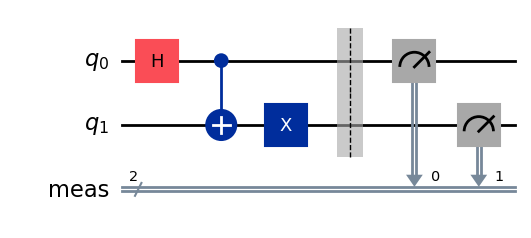

Contagem de resultados: {'01': 507, '10': 517}


In [3]:
# Importando as bibliotecas necessárias
from qiskit import QuantumCircuit # 'execute' e 'Aer' removidos desta linha
from qiskit_aer import Aer       # 'Aer' importado de 'qiskit_aer'
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display # Necessário para display() usado posteriormente

# Configuração para exibir plots do matplotlib inline no notebook
%matplotlib inline

# Criando um circuito quântico com 2 qubits
circuit = QuantumCircuit(2)

# Aplicando a porta Hadamard no primeiro qubit
circuit.h(0)

# Aplicando a porta CNOT, onde o primeiro qubit controla o segundo
circuit.cx(0, 1)

# Adicionando uma porta Pauli (X) para simular bloqueios em um dos caminhos
# Aqui vamos aplicar a porta X no segundo qubit, simulando um caminho bloqueado
circuit.x(1)

# Medindo os qubits
circuit.measure_all()

# Desenhando o circuito (como no script original)
print("--- Desenho do Circuito Inicial ---")
circuit.draw('mpl')
plt.show()

# Simulando o circuito inicial
simulator = Aer.get_backend('qasm_simulator') # Mantendo 'qasm_simulator'
# CORREÇÃO ESSENCIAL: Substituindo execute(...) por simulator.run(...)
result = simulator.run(circuit, shots=1024).result()
counts = result.get_counts(circuit)

# Exibindo os resultados do circuito inicial (como no script original)
print("Contagem de resultados:", counts)

## 2. Modelo Simbólico dos Estados dos Sensores IoT

Para representar os sensores em nosso sistema de evacuação, definimos uma classe simples chamada `SensorIoT`. Cada instância desta classe terá:
- `nome`: Uma string identificando o sensor (ex: "Fumaça", "Obstrução").
- `estado`: Um valor numérico (0 ou 1) representando o estado do sensor:
    - `0`: Indica que o sensor não detectou perigo (condição segura).
    - `1`: Indica que o sensor detectou perigo (condição de alerta).

In [5]:
# 1. Modelo Simbólico dos Estados dos Sensores
class SensorIoT:
    def __init__(self, nome, estado):
        self.nome = nome  # Ex: "Fumaça", "Temperatura", "Obstrução"
        self.estado = estado  # 0 (seguro) ou 1 (perigoso)

## 3. Circuito Quântico para Tomada de Decisão de Evacuação

A função `circuito_evacuacao` é projetada para criar um circuito quântico que modela a decisão de evacuação com base nos dados de dois sensores principais.

**Detalhes do Circuito:**
- **Qubits**: Utiliza 3 qubits.
    - `qubit 0`: Representa o estado do primeiro sensor (ex: Fumaça).
    - `qubit 1`: Representa o estado do segundo sensor (ex: Obstrução).
    - `qubit 2`: Atua como um qubit de "decisão" ou "resultado".
- **Bits Clássicos**: Utiliza 2 bits clássicos para armazenar os resultados das medições.

**Lógica do Circuito:**
1.  **Codificação dos Sensores**: Se um sensor está em estado de perigo (`estado == 1`), uma porta X (NOT quântico) é aplicada ao qubit correspondente.
2.  **Superposição**: Portas Hadamard (H) são aplicadas aos qubits dos sensores (`qubit 0` e `qubit 1`).
3.  **Entrelaçamento e Decisão**: Portas CNOT são usadas para correlacionar os estados dos sensores com o qubit de decisão (`qubit 2`).
4.  **Medição**: O `qubit 0` é medido no `bit clássico 0`, e o `qubit 2` (decisão) é medido no `bit clássico 1`. Resultados no formato `c1c0`.

In [6]:
# 2. Circuito Quântico para Tomada de Decisão
def circuito_evacuacao(sensores):
    qc = QuantumCircuit(3, 2)  # 3 qubits (2 para sensores + 1 para decisão)
    
    # Codificação dos dados dos sensores nos qubits
    for i, sensor in enumerate(sensores[:2]):  # Usando 2 sensores principais
        if sensor.estado == 1:  # Se sensor detecta perigo
            qc.x(i)  # Aplica porta X (Pauli-X)
    
    # Superposição para explorar múltiplos caminhos
    qc.h(0)  # Porta Hadamard no primeiro sensor
    qc.h(1)  # Porta Hadamard no segundo sensor
    
    # Entrelaçamento para correlação entre sensores
    qc.cx(0, 2)  # CNOT: qubit 0 controla o qubit 2 (decisão)
    qc.cx(1, 2)  # CNOT: qubit 1 também influencia a decisão
    
    # Medição apenas dos qubits de decisão
    qc.measure([0, 2], [0, 1])  # Mede caminho (0) e decisão (2)
    
    return qc

## 4. Simulação com Diferentes Cenários de Perigo

Definição da função `simular_cenarios`. A execução da simulação dentro desta função foi adaptada para usar `NOMEDOSIMULADOR.run(...)`. As demais lógicas, nomes de variáveis (`cenarios`, `cenario`, `qc`, `simulator`, `result`, `counts`) e a estrutura de plotagem com `display(plot_histogram(counts))` são mantidas como no script original.

In [7]:
# 3. Simulação com Diferentes Cenários
# 'display' já foi importado na Célula 5
# 'Aer' já foi importado na Célula 5

def simular_cenarios():
    # Cenários de teste (como no script original)
    cenarios = [
        [SensorIoT("Fumaça", 0), SensorIoT("Obstrução", 0)],  # Tudo seguro
        [SensorIoT("Fumaça", 1), SensorIoT("Obstrução", 0)],  # Fumaça detectada
        [SensorIoT("Fumaça", 0), SensorIoT("Obstrução", 1)],  # Caminho bloqueado
        [SensorIoT("Fumaça", 1), SensorIoT("Obstrução", 1)]   # Ambos perigosos
    ]
    
    # Simular cada cenário (como no script original)
    for i, cenario in enumerate(cenarios):
        print(f"\n=== Cenário {i+1} ===")
        print(f"Sensor Fumaça: {'Perigo' if cenario[0].estado else 'Seguro'}")
        print(f"Sensor Obstrução: {'Perigo' if cenario[1].estado else 'Seguro'}")
        
        qc = circuito_evacuacao(cenario)
        # A linha abaixo é repetida a cada iteração do loop, como no script original.
        simulator = Aer.get_backend('qasm_simulator')
        # CORREÇÃO ESSENCIAL: Substituindo execute(...) por simulator.run(...)
        result = simulator.run(qc, shots=1000).result()
        # 'counts' aqui é uma variável local para a função/loop, como no script original.
        counts = result.get_counts(qc)
        
        # Visualização (como no script original)
        print("\nDistribuição de Probabilidades:")
        display(plot_histogram(counts, title=f'Resultados Cenário {i+1}')) # Adicionado título para clareza
        
        # Interpretação dos resultados (como no script original)
        print("\nRecomendação de Evacuação:")
        if '00' in counts and counts['00'] > 600:
            print("✅ Rota Principal Segura")
        elif '01' in counts and counts['01'] > 600:
            print("⚠️ Usar Rota Alternativa 1")
        elif '10' in counts and counts['10'] > 600:
            print("⚠️ Usar Rota Alternativa 2")
        else:
            print("🚨 EVACUAÇÃO DE EMERGÊNCIA! Usar saídas alternativas")

## 5. Execução Final

Execução do plot do histograma para a variável `counts` global (do primeiro circuito) e chamada da função `simular_cenarios`, conforme o script original.


--- Histograma Final (do primeiro circuito simulado no início) ---


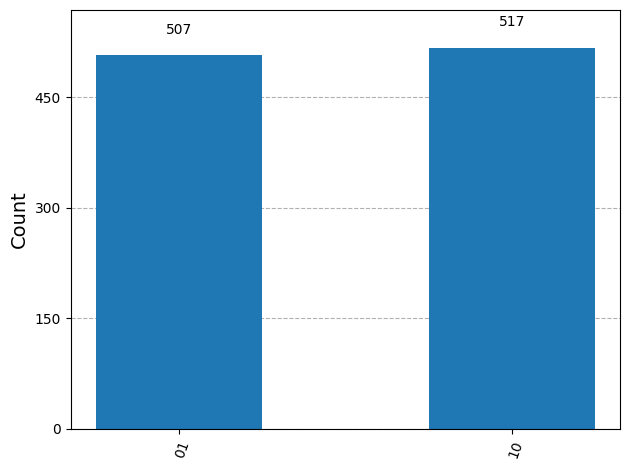


=== Cenário 1 ===
Sensor Fumaça: Seguro
Sensor Obstrução: Seguro

Distribuição de Probabilidades:


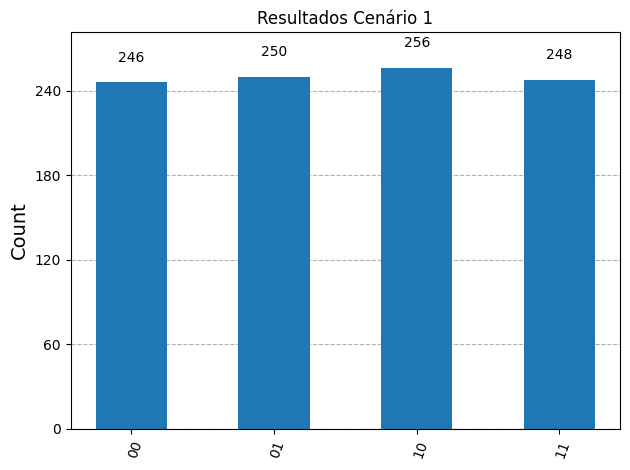


Recomendação de Evacuação:
🚨 EVACUAÇÃO DE EMERGÊNCIA! Usar saídas alternativas

=== Cenário 2 ===
Sensor Fumaça: Perigo
Sensor Obstrução: Seguro

Distribuição de Probabilidades:


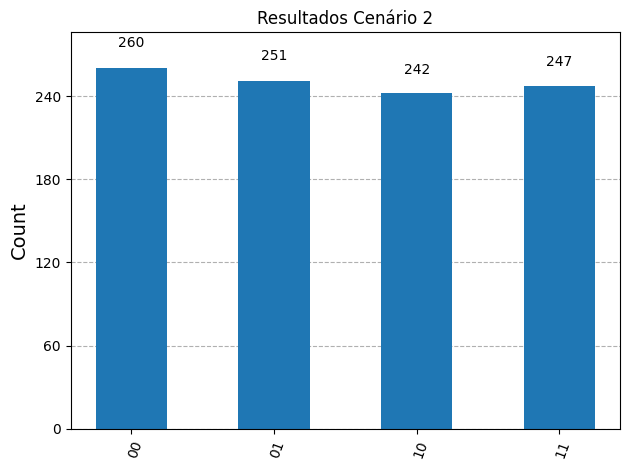


Recomendação de Evacuação:
🚨 EVACUAÇÃO DE EMERGÊNCIA! Usar saídas alternativas

=== Cenário 3 ===
Sensor Fumaça: Seguro
Sensor Obstrução: Perigo

Distribuição de Probabilidades:


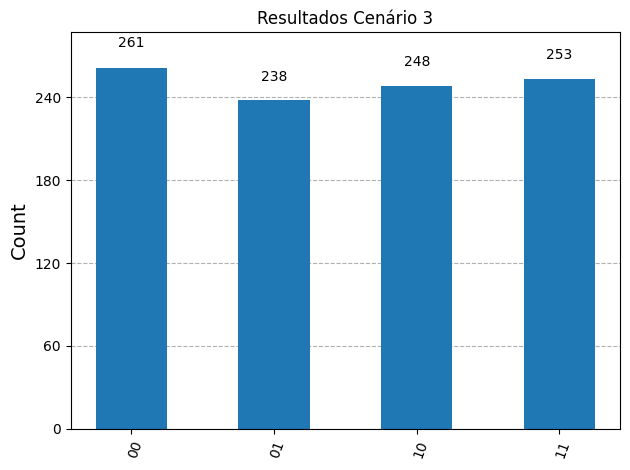


Recomendação de Evacuação:
🚨 EVACUAÇÃO DE EMERGÊNCIA! Usar saídas alternativas

=== Cenário 4 ===
Sensor Fumaça: Perigo
Sensor Obstrução: Perigo

Distribuição de Probabilidades:


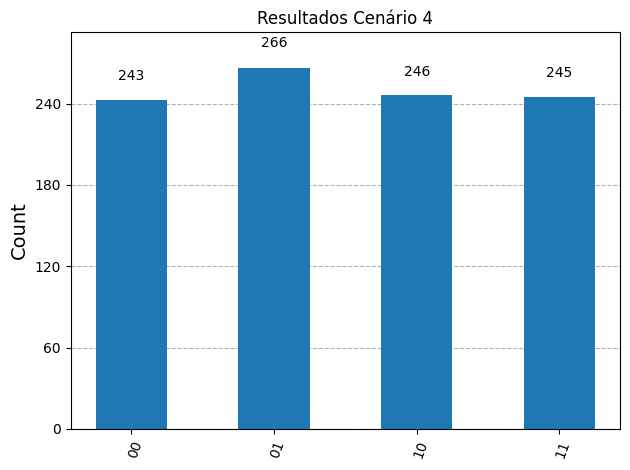


Recomendação de Evacuação:
🚨 EVACUAÇÃO DE EMERGÊNCIA! Usar saídas alternativas


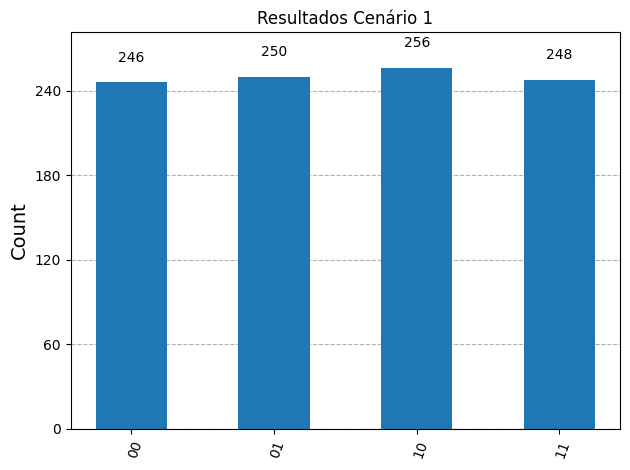

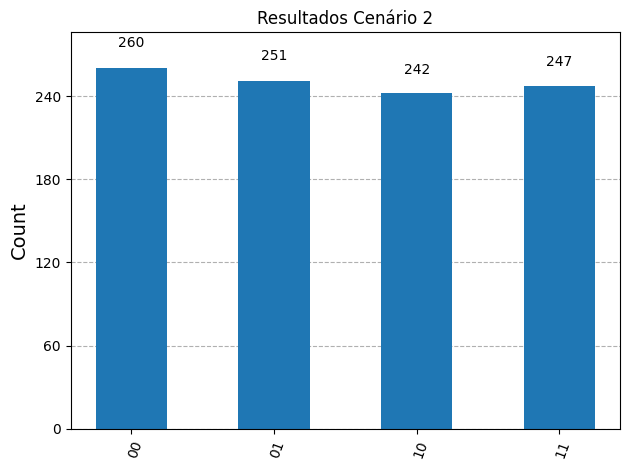

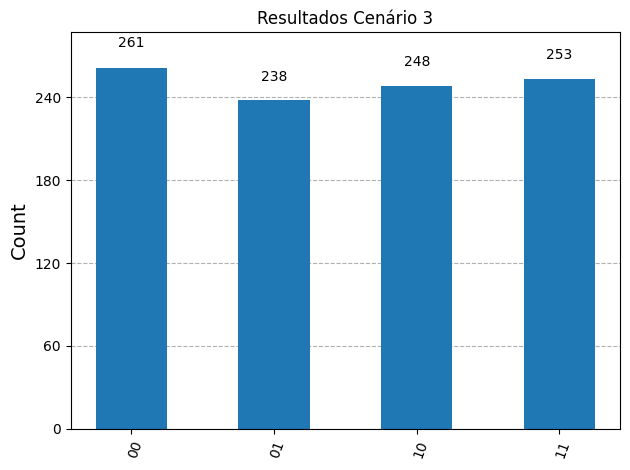

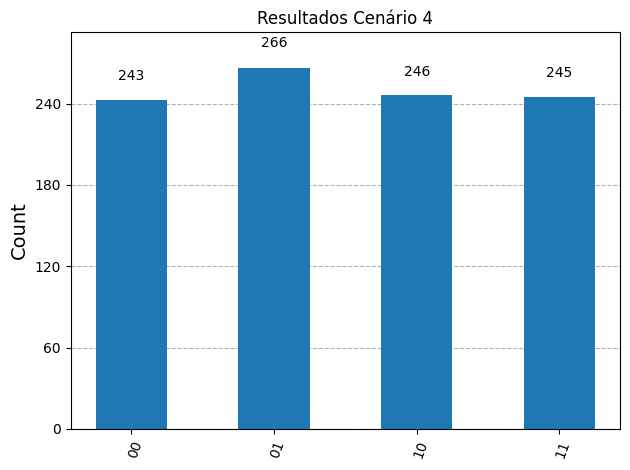

In [8]:
# Plotando o histograma dos resultados (do PRIMEIRO circuito simulado na Célula 5)
# 'counts' aqui refere-se à variável global da Célula 5.
print("\n--- Histograma Final (do primeiro circuito simulado no início) ---")
plot_histogram(counts)
plt.show()

# 4. Executar a simulação (como no script original)
simular_cenarios()